In this project we will look at predicting COVID mortality due to pre-existing conditions. This is a classification problem, and so we will use different classifcation models to see which is best

In [40]:
# Import libraries and data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
covid = pd.read_csv("C:\\Users\\user\\Desktop\\Data\\covid.csv")
covid.head() # Check our data looks right

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2


In [41]:
# Lots of columns - let's see what they are and drop those we don't need
covid.columns

Index(['id', 'sex', 'patient_type', 'entry_date', 'date_symptoms', 'date_died',
       'intubed', 'pneumonia', 'age', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco', 'contact_other_covid',
       'covid_res', 'icu'],
      dtype='object')

In [42]:
# We're not interested in patient ID,entry date, date of symptoms, type of patient, covid res or icu - we want prexisting "conditions"
covid.drop(["id", "patient_type", "entry_date", "date_symptoms", "intubed", "covid_res", "icu"], axis=1, inplace=True)
covid.head()

,sex,date_died,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid
0,2,9999-99-99,2,27,97,2,2,2,2,2,2,2,2,2,2,2
1,2,9999-99-99,2,24,97,2,2,2,2,2,2,2,2,2,2,99
2,1,9999-99-99,2,54,2,2,2,2,2,2,2,2,1,2,2,99
3,2,9999-99-99,1,30,97,2,2,2,2,2,2,2,2,2,2,99
4,1,22-04-2020,2,60,2,1,2,2,2,1,2,1,2,2,2,99


In [43]:
# We need to change the date died column to binary values
covid["date_died"].describe()

count         566602
unique           124
top       9999-99-99
freq          530426
Name: date_died, dtype: object

In [44]:
covid["date_died"] = covid["date_died"].str.replace("9999-99-99", "2") # Make every surival "2"

In [45]:
covid["date_died"] = covid["date_died"].str.replace("\d\d-\d\d-\d\d\d\d", "1") # Make every death "1"

In [46]:
covid["date_died"][:10]

0    2
1    2
2    2
3    2
4    1
5    1
6    2
7    2
8    2
9    2
Name: date_died, dtype: object

In [47]:
# Inspect for null values
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566602 entries, 0 to 566601
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   sex                  566602 non-null  int64 
 1   date_died            566602 non-null  object
 2   pneumonia            566602 non-null  int64 
 3   age                  566602 non-null  int64 
 4   pregnancy            566602 non-null  int64 
 5   diabetes             566602 non-null  int64 
 6   copd                 566602 non-null  int64 
 7   asthma               566602 non-null  int64 
 8   inmsupr              566602 non-null  int64 
 9   hypertension         566602 non-null  int64 
 10  other_disease        566602 non-null  int64 
 11  cardiovascular       566602 non-null  int64 
 12  obesity              566602 non-null  int64 
 13  renal_chronic        566602 non-null  int64 
 14  tobacco              566602 non-null  int64 
 15  contact_other_covid  566602 non-nu

In [48]:
# We have no null values, but we do have lots of "99s" and "97s", which have been put in there in place of NaN. Let's visualise this
for column in covid.columns:
    print(covid[column].value_counts())

2    287112
1    279490
Name: sex, dtype: int64
2    530426
1     36176
Name: date_died, dtype: int64
2     478416
1      88175
99        11
Name: pneumonia, dtype: int64
30     14604
31     13911
36     13890
38     13847
37     13836
       ...  
118        1
117        1
116        1
115        1
111        1
Name: age, Length: 120, dtype: int64
97    287112
2     273840
1       4063
98      1587
Name: pregnancy, dtype: int64
2     493790
1      70831
98      1981
Name: diabetes, dtype: int64
2     555723
1       9130
98      1749
Name: copd, dtype: int64
2     546824
1      18026
98      1752
Name: asthma, dtype: int64
2     555644
1       8978
98      1980
Name: inmsupr, dtype: int64
2     472270
1      92508
98      1824
Name: hypertension, dtype: int64
2     546920
1      17084
98      2598
Name: other_disease, dtype: int64
2     552005
1      12775
98      1822
Name: cardiovascular, dtype: int64
2     472549
1      92272
98      1781
Name: obesity, dtype: int64
2     553560
1  

Our 97, 98 and 99 values appear in the binary columns (oddly, these columns have 2 and 1 rather than 1 and 0). We will convert them to NaNs and see how many we have.

In [49]:
columns = ["pneumonia", "pregnancy", "diabetes", "copd", "asthma", "inmsupr", "hypertension", "other_disease", "cardiovascular", "obesity",
           "renal_chronic", "tobacco", "contact_other_covid"]

for col in columns:
    covid[col] = [i if i == 2 or i == 1 else None for i in covid[col]]

covid.head()

,sex,date_died,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid
0,2,2,2.0,27,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,2,2,2.0,24,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN
2,1,2,2.0,54,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,NaN
3,2,2,1.0,30,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN
4,1,1,2.0,60,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,NaN


In [50]:
print(covid.isna().sum())

sex                         0
date_died                   0
pneumonia                  11
age                         0
pregnancy              288699
diabetes                 1981
copd                     1749
asthma                   1752
inmsupr                  1980
hypertension             1824
other_disease            2598
cardiovascular           1822
obesity                  1781
renal_chronic            1792
tobacco                  1907
contact_other_covid    175031
dtype: int64


Our dataset is 500000 rows, and the pregnancy column has 288699 missing values, so we will drop that completely. Similarly, the contact_other_covid column is missing nearly a third of its values, so we will drop that. In the rest of the dataset, if we fill the NaN with the mean of that column, it will just give us a value between 1 and 2, and so won't throw our model too much. We'll therefore use fillna(.mean) to replace these values.

In [51]:
covid.drop(["pregnancy", "contact_other_covid"], axis=1, inplace=True)
covid = covid.fillna(covid.mean())
covid.head()
covid.isna().sum()

sex               0
date_died         0
pneumonia         0
age               0
diabetes          0
copd              0
asthma            0
inmsupr           0
hypertension      0
other_disease     0
cardiovascular    0
obesity           0
renal_chronic     0
tobacco           0
dtype: int64

Now, a quick note on what our dataset contains. Almost all columns are filled with 2s and 1s (or the mean of that column, as we just discussed). In the disease columns, a 2 means the disease wasn't present and 1 means that it was. For sex, 2 is women and 1 is men. First, we'll use all of our columns to build a classification model to see how accurately it can predict death from covid.

In [52]:
from sklearn.linear_model import LogisticRegression # import our classification algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
features = ["sex", "pneumonia", "age", "diabetes", "copd", "asthma", "inmsupr", "hypertension", "other_disease", "cardiovascular", "obesity",
           "renal_chronic", "tobacco"]
x = covid[features]
y = covid["date_died"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
lr = LogisticRegression(max_iter=500)
lr.fit(x_train, y_train)
lr_predictions = lr.predict(x_test)
lr_accuracy = accuracy_score(lr_predictions, y_test)
print("Logistic regression accuracy:", lr_accuracy)
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
clf_predictions = clf.predict(x_test)
clf_accuracy = accuracy_score(clf_predictions, y_test)
print("Decision tree accuracy:", clf_accuracy)
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_predictions = rf.predict(x_test)
rf_accuracy = accuracy_score(rf_predictions, y_test)
print("Random forest accuracy:", rf_accuracy)







Logistic regression accuracy: 0.9333432167792673
Decision tree accuracy: 0.9286979971902775
Random forest accuracy: 0.9312959315500773


We have three pretty accurate models here, all around 93% accuracy. Can we fine-tune the model further to make it even more accurate. One thing we could do is try to choose features that are more closely correlated with the target column - if we plot a correlation heatmap we can see which these are.

In [53]:
covid["date_died"] = covid["date_died"].astype(float)

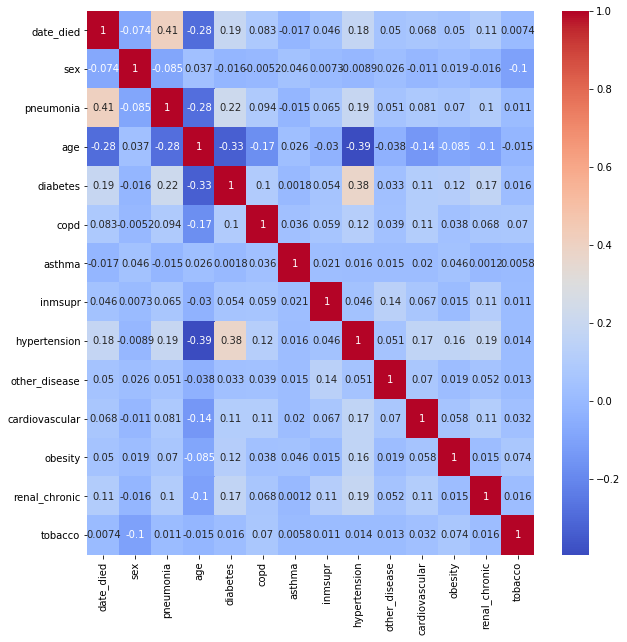

In [54]:
correlation_columns = covid[["date_died", "sex", "pneumonia", "age", "diabetes", "copd", "asthma", "inmsupr", "hypertension", "other_disease", "cardiovascular", "obesity",
           "renal_chronic", "tobacco"]]
plt.subplots(figsize=(10,10))
sns.heatmap(correlation_columns.corr(), cmap="coolwarm", annot=True)
plt.show()

If we look at the "date_died" column we see that, in fact, only pneumonia has a particularly strong correlation with death. This might indicate that the accuracy of the model is more to do with the fact that it only has to predict one of two states, and so we would expect the accuracy of the model to be around 50% if our model just selected randomly. Let's pick a few of the most correlated features to see if this bears out. We will take features where correlation is -0.1 > x > 0.1, so renal_chronic, hypertension, diabetes, pneumonia and age.

In [55]:
features = ["age", "pneumonia", "diabetes", "hypertension",
           "renal_chronic"]
x = covid[features]
y = covid["date_died"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_predictions = lr.predict(x_test)
lr_accuracy = accuracy_score(lr_predictions, y_test)
print("Logistic regression accuracy:", lr_accuracy)
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)
clf_predictions = clf.predict(x_test)
clf_accuracy = accuracy_score(clf_predictions, y_test)
print("Decision tree accuracy:", clf_accuracy)
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_predictions = rf.predict(x_test)
rf_accuracy = accuracy_score(rf_predictions, y_test)
print("Random forest accuracy:", rf_accuracy)

Logistic regression accuracy: 0.9331455478605869
Decision tree accuracy: 0.9344515746447254
Random forest accuracy: 0.9344727534574412


The logistic regression model actually got slightly worse here (0.9331 vs 0.9333), whereas we saw slight improvement in the decision tree (0.9345 vs 0.9287) and the random forest models (0.9346 0.9312). Of all the model, the random forest model with strongly correlated features performed the best, but the difference really is negligible.